# **Обучение модели и анализ процессов принятия решений внутри модели.**

В этом ноутбуке по результатам EDA (`Shoppers_EDA.ipynb`) производится обучение моделей машинного обучения для решения задачи прогнозирования наличия выручки от пользователей. 

В ноутбуке приведены:

- анализ влияния количества признаков на качество базовой модели
- анализ качества различных моделей на лучшем сочетании признаков 
- подбор гиперпараметров с целью повысить качество базовых моделей 
- анализ применения базовых методик устранения дисбаланса классов для решения задачи 
- выбор лучшей модели для решения задачи

Для более детализированного анализа моделей, помимо основной метрики применены методики интерпретации моделей – shapley values и permutation importance.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import eli5
import shap
from eli5.sklearn import PermutationImportance

In [2]:
#Отключен Warning связанный с необходимыми версиями библиотек

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## **1. Загрузка данных.**

В ходе EDA данные были разделены на два набора:
- `cleaned_data.csv` — предобработанный набор данных (устранены пропущенные значения путем заполнения и удаления части данных), содержащий все признаки
- `df_significant.csv` — набор данных, содержащий только признаки, показавшие себя значимыми при статистическом анализе, пропущенные значения заполнены аналогично набору данных 1, но необходимость удаления части данных устранена удалением незначимого признака. 

In [3]:
df = pd.read_csv('./data/cleaned_data.csv', index_col=0)
df_significant = pd.read_csv('./data/df_significant.csv', index_col=0)

In [4]:
df_significant.head(3)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue
0,0,0,1,0.2,0.0,0.0,0
1,0,0,2,0.0,0.0,0.0,0
2,0,0,1,0.2,0.0,0.0,0


In [5]:
df.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,SpecialDay_categorical
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,1,1,1,1,1,False,0,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,1,2,2,1,2,1,False,0,0
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,4,1,9,3,1,False,0,0


**Объявление вспомогательных функций.**

In [6]:
def get_train_test_data(X, y, scaler=None):

    """
    Функция, разделящая наборы данных на тренировочный и тестовые наборы данных.
    В случае необходимости, функция позволяет применить нормализацию признаков при помощи преобразователей
    из модуля sklearn.preprocessing. 
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    if scaler != None:

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test

    else:
        
        return X_train.values, X_test.values, y_train, y_test
        
    
def get_train_report(model, X_train, X_test, y_train, y_test, description):  

    """
    Функция, дающая отчет о качестве обученной модели.
   
    Показывает распределение классов в тренировочной и тестовой выборках.
   
    Возвращает:
    - обученную модель, 
    - данные, на которых обучена модель (train, test), 
    - метрики обучения: 
        classification report (f1, precision, recall, accuracy), 
        balanced accuracy на кросс валидации, 
        balanced accuracy на тестовых данных.
        
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    x1 = y_train.value_counts().reset_index().iloc[:, 0]
    y1 = y_train.value_counts().reset_index().iloc[:, 1]

    x2 = y_train.value_counts().reset_index().iloc[:, 0]
    y2 = y_train.value_counts().reset_index().iloc[:, 1]
    
    ax1.bar(x1, y1)
    ax1.set_xticks([0, 1])
    ax1.set_title('Распределение классов в тренировочных данных', pad=15)

    ax2.bar(x2, y2, color='orange')
    ax2.set_xticks([0, 1])
    ax2.set_title('Распределение классов в тестовых данных', pad=15)
    
    fig.suptitle(description, y=1.05)
    
    plt.show()
    
    #Обучение модели
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    
    #Оценка качества
    clf_report = classification_report(y_test, predictions)

    cv = cross_validate(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
    balanced_accuracy_val = cv['test_score'].mean()
    balanced_accuracy_test = balanced_accuracy_score(y_test, predictions)
    
    print(clf_report)
    print(f'Mean val balanced accuracy (5 folds): {balanced_accuracy_val}')
    print(f'Test balanced Accuracy: {balanced_accuracy_test}')
    
    return model, (X_train, X_test, y_train, y_test), (clf_report, balanced_accuracy_val, balanced_accuracy_test)
 
    

In [7]:
def get_comparative_barplot(names, metrics, description):

    """
    Функция, для визуализации качества обученных оценщиков. 
    Значение качества для оценщика с наибольшим значением метрики подсвечено хеленых цветом.
    """

    plt.figure(figsize=(16, 4))
    bar = plt.bar(names, metrics)
    bar.get_children()[np.argmax(metrics)].set_color('g')
    
    plt.bar_label(bar, padding=-25, color='white');
    
    plt.title(description, pad=15);

## **2. Обучение базовых алгоритмов на полном наборе данных.**

В качестве базовых алгоримов выбраны классификатор, основанный на методе ближайших соседей (KNN) и классификатор, основанный на теореме Байеса (GaussianNB). 

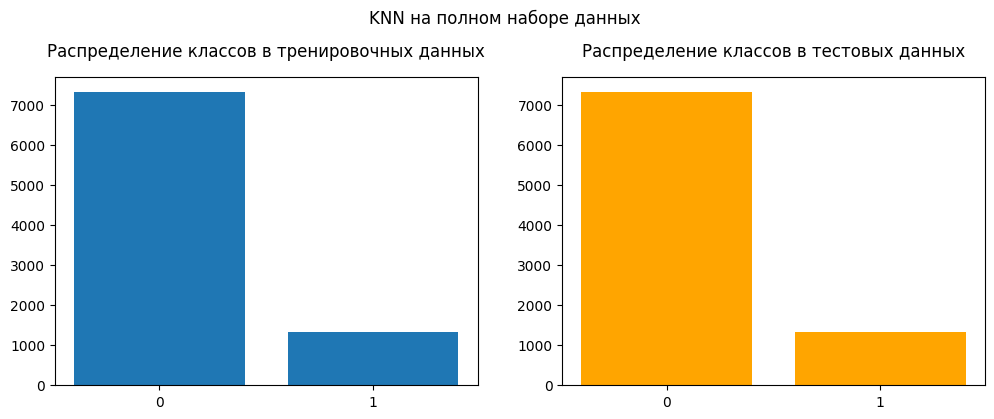

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2460
           1       0.50      0.19      0.27       429

    accuracy                           0.85      2889
   macro avg       0.69      0.58      0.60      2889
weighted avg       0.82      0.85      0.82      2889

Mean val balanced accuracy (5 folds): 0.5949443079841666
Test balanced Accuracy: 0.5781454318039684


In [67]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_all, knn_all_data, knn_all_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на полном наборе данных')

**Выводы: обучение на полном наборе данных, KNN**

1. Точность (precision) для целевого класса `0.5` таким образом, базовый оценщик в виде KNN ошибочно прогнозирует, что клиент принесет выручку (revenue=1) для 50% спрогнозированных наблюдений, при этом полнота (recall) `0.19`, говорит о том, что оценщик находит `~ 20%` клиентов, принесших выручку.
2. При этом оценщик ошибочно прогнозирует, что клиент не принесет выручку для `13%` наблюдений, и пропускает только `3%` клиентов, которые выручку  не приносят

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning:

divide by zero encountered in log



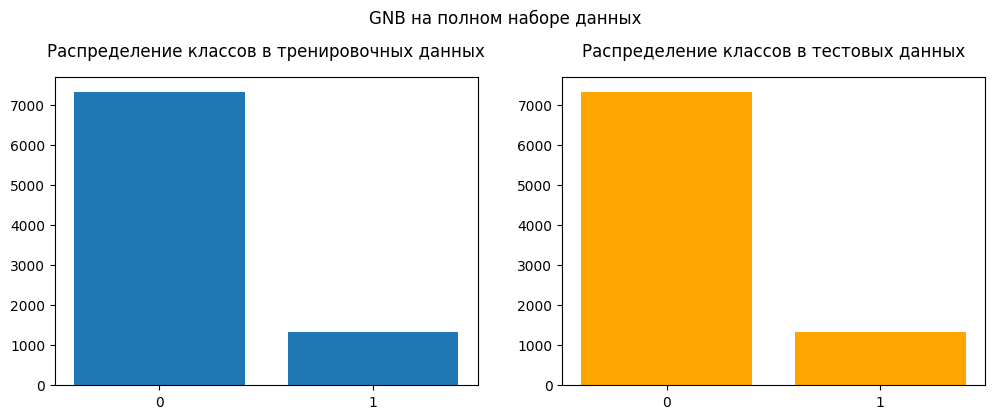

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2460
           1       0.47      0.77      0.58       429

    accuracy                           0.83      2889
   macro avg       0.71      0.81      0.74      2889
weighted avg       0.88      0.83      0.85      2889

Mean val balanced accuracy (5 folds): 0.7987958948548679
Test balanced Accuracy: 0.8087483654556825


In [68]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gnb = GaussianNB()
gnb_all, gnb_all_data, gnb_all_metrics = get_train_report(gnb, np.array(X_train), np.array(X_test), y_train, y_test, 
                                                          'GNB на полном наборе данных')


**Выводы: обучение на полном наборе данных, GNB**

1. Точность (precision) для целевого класса revenue = 1 `0.47` таким образом, базовый оценщик в виде GNB ошибочно прогнозирует, что клиент принесет выручку (revenue=1) для 53% спрогнозированных наблюдений, при этом полнота (recall) `0.77`, говорит о том, что оценщик находит уже `~ 77%` клиентов, принесших выручку.
2. При этом оценщик ошибочно прогнозирует, что клиент не принесет выручку для `4%` наблюдений, и пропускает `15%` клиентов, которые выручку не приносят.

**Выводы: обучение базовых оценщиков**

1. Предположительно дисбаланс классов вызывает лучшие показатели в распознавании наблюдений с целевой переменной, равной 0 (алгоритмы лучше распознают клиентов, не приносящих выручку).

2. В дальнейшем для построения ML системы необходимо уточнить бизнес-цель прогноза наличия/отсутствия вырчуки. Если, например, цель выделить клиентов, не приносящих выручку, то стоит отдавать предпочтение оценщикам, пропускающих меньший процент клиентов, не приносящих выручку (то есть повышать recall (полноту) для класса 0). Если же цель в выделении бюджета на более горячих клиентов и цель прогнозировать класс потенциальных покупателей, необходимо сосредоточиться на классе 1 и либо также выбирать алгоритмы, хорошо распознающие класс revenue = 0, либо сосредотачиваться на повышении precision и recall данного класса способами для устранения дисбаланса классов. Если же одинаково важны оба класса (например, цели прогнозирования обоих классов одинаково важны в данный момент), за основу в выборе можно взять метрику сбалансированной точности (balanced accuracy)

## **3. Обучение базовых алгоритмов на сокращенном наборе данных.**

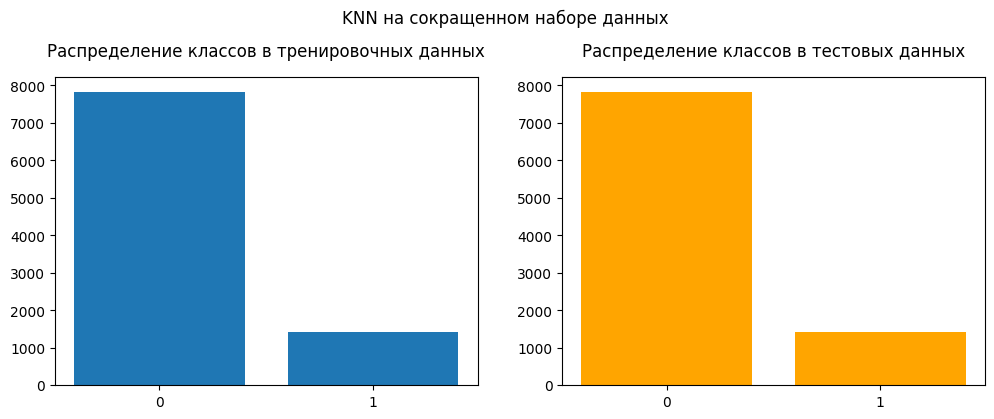

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2594
           1       0.69      0.46      0.55       489

    accuracy                           0.88      3083
   macro avg       0.80      0.71      0.74      3083
weighted avg       0.87      0.88      0.87      3083

Mean val balanced accuracy (5 folds): 0.7247085017127362
Test balanced Accuracy: 0.7104005941034288


In [71]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_sign, knn_sign_data, knn_sign_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на сокращенном наборе данных')

In [72]:
print(knn_all_metrics[0])

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2460
           1       0.50      0.19      0.27       429

    accuracy                           0.85      2889
   macro avg       0.69      0.58      0.60      2889
weighted avg       0.82      0.85      0.82      2889



**Выводы: обучение на наборе данных с меньшим количеством признаков, KNN**

1. Обучение на сокращенном наборе данных для KNN привело к улучшению качества распознавания клиентов, приносящих выручку. Алгоритм ошибочно прогнозирует наличие выручки в `31%` случаев и при этом находит уже `46%` клиентов, которые выручку принесли. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning:

divide by zero encountered in log



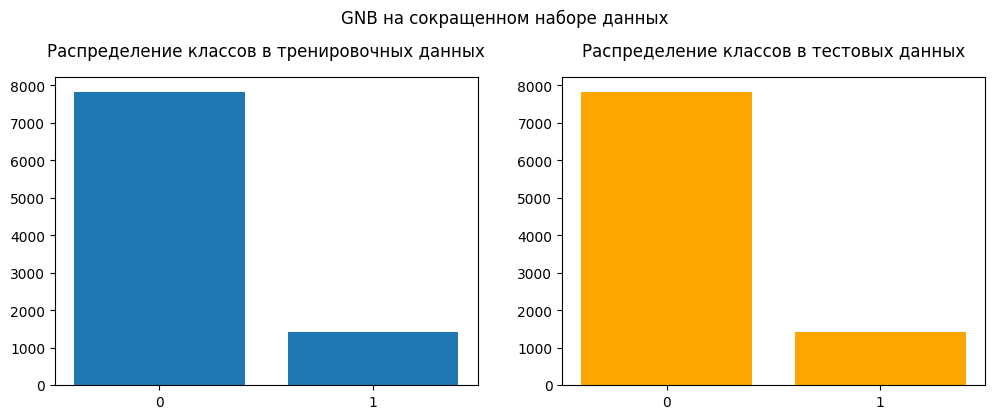

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2594
           1       0.56      0.73      0.63       489

    accuracy                           0.87      3083
   macro avg       0.75      0.81      0.78      3083
weighted avg       0.88      0.87      0.87      3083

Mean val balanced accuracy (5 folds): 0.8073915834526962
Test balanced Accuracy: 0.8095932409698013


In [73]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df_significant.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb = GaussianNB()

gnb_sign, gnb_sign_data, gnb_sign_metrics = get_train_report(gnb, X_train, X_test, y_train, y_test, 'GNB на сокращенном наборе данных')

**Выводы: обучение на наборе данных с меньшим количеством признаков, GNB**

1. Обучение на сокращенном наборе данных для GNB аналогично привело к улучшению качества распознавания клиентов, приносящих выручку. Алгоритм ошибочно прогнозирует наличие выручки в `44%` случаев, но находит `73%` клиентов, которые выручку принесли. 

**Выводы: обучение базовых оценщиков на наборе данных с меньшим количеством признаков**

1. Уменьшение количества признаков приводит к улучшению качества базовых алгоритмов в задаче нахождения клиентов, приносящих выручку. При этом качество нахождения клиентов, не приносящих выручку изменятся в пределах 5% по метрикам точности (precision) и полноты (recall). Вследствие этого, далее протестированы другие возможные варианты базовых оценщиков для решения данной задачи. 

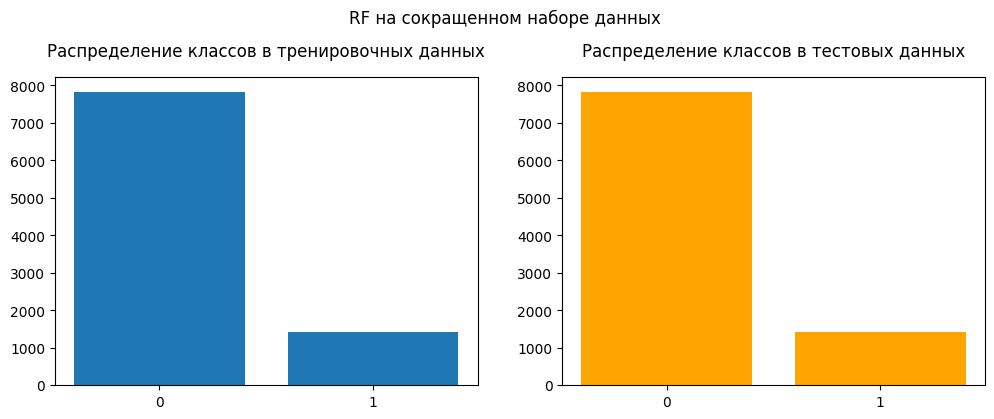

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2594
           1       0.67      0.52      0.59       489

    accuracy                           0.88      3083
   macro avg       0.79      0.74      0.76      3083
weighted avg       0.88      0.88      0.88      3083

Mean val balanced accuracy (5 folds): 0.7401281686945108
Test balanced Accuracy: 0.7370276381077616


In [74]:
from sklearn.ensemble import RandomForestClassifier

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

rf = RandomForestClassifier()
rf_sign, rf_sign_data, rf_sign_metrics = get_train_report(rf, X_train, X_test, y_train, y_test, 'RF на сокращенном наборе данных')

**Выводы: обучение на наборе данных с меньшим количеством признаков, Random Forest**

1. Обучение на сокращенном наборе данных для RF дает схожие для KNN и GNB показатели при прогнозировании клиентов, не приносящих выручку. При этом, алгоритм ошибочно прогнозирует наличие выручки в 32% случаев и находит 53% клиентов, которые выручку принесли.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning:

divide by zero encountered in log



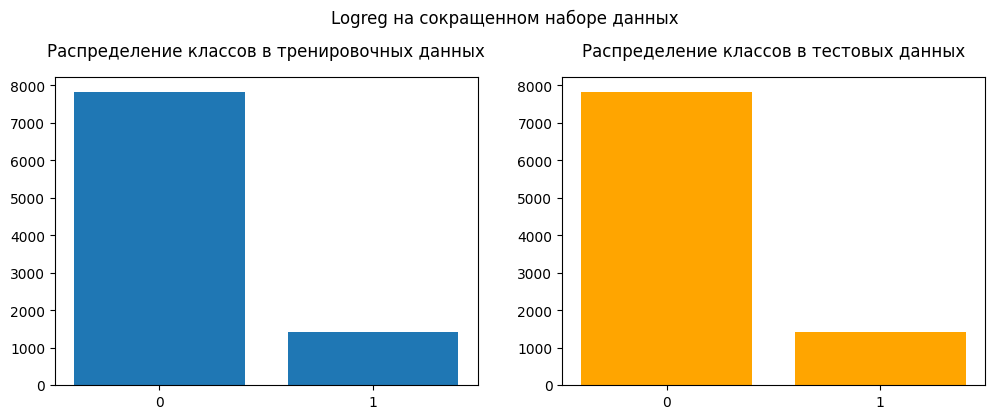

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2594
           1       0.67      0.52      0.58       489

    accuracy                           0.88      3083
   macro avg       0.79      0.73      0.76      3083
weighted avg       0.87      0.88      0.88      3083

Mean val balanced accuracy (5 folds): 0.7522718744728586
Test balanced Accuracy: 0.7341529059509675


In [75]:
from sklearn.linear_model import LogisticRegression

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df_significant.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

lr = LogisticRegression()
lr_sign, lr_sign_data, lr_sign_metrics = get_train_report(lr, X_train, X_test, y_train, y_test, 'Logreg на сокращенном наборе данных')

**Выводы: обучение на наборе данных с меньшим количеством признаков, Logistic Regression**

Обучение на сокращенном наборе данных для LR также дает схожие для KNN и GNB показатели при прогнозировании клиентов, не приносящих выручку. При этом, алгоритм показывает схожие с RF показатели — ошибочно прогнозирует наличие выручки в 33% случаев и находит 52% клиентов, которые выручку принесли.

**Сравнительный график протестированных оценщиков по метрике balanced accuracy.**

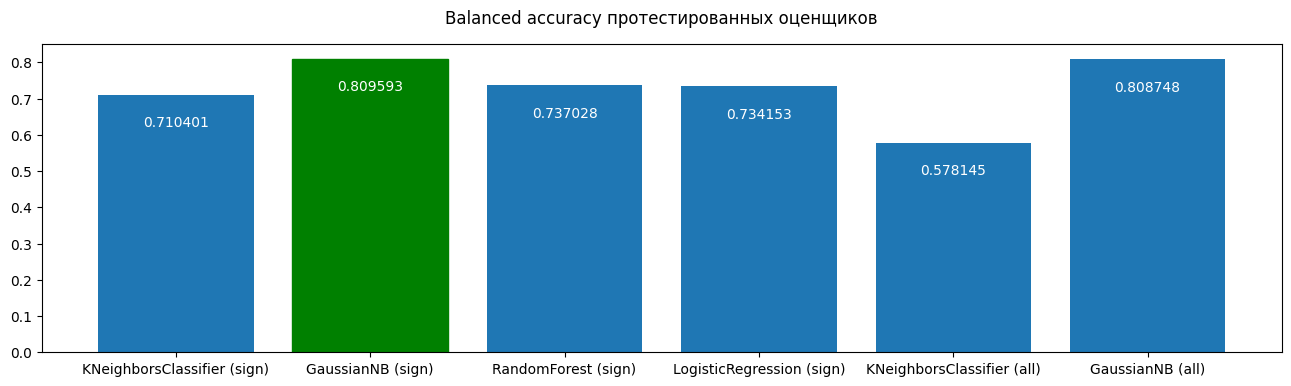

In [76]:
estimators = ['KNeighborsClassifier (sign)', 'GaussianNB (sign)', 'RandomForest (sign)', 'LogisticRegression (sign)',
              'KNeighborsClassifier (all)', 'GaussianNB (all)']
balanced_accuracy = [knn_sign_metrics[2], gnb_sign_metrics[2], rf_sign_metrics[2], lr_sign_metrics[2], knn_all_metrics[2], gnb_all_metrics[2]]


get_comparative_barplot(estimators, balanced_accuracy, 'Balanced accuracy протестированных оценщиков')

**Общий вывод:**

1. В данной задаче целесообразно применение либо алгоритма ближайших соседей, либо Байесовского классификатора как наиболее простых и наиболее качественных по целевым метрикам моделей.
2. Сокращение количества признаков (и увеличение количества наблюдений на 7%) приводит к улучшению качества распознавания клиентов, приносящих выручку.
3. Выбор лучшего алгоритма тесно связан с бизнес-целью. Если более важно определение клиентов, не приносящих выручку за лучший алгоритм валидно принять KNN, если же наоборот важны именно клиенты, выручку приносящие или если оба класса важны одинаково, за лучший алгоритм следует принять GNB. В данной работе решено сосредоточиться на повышении точности для обоих классов одновременно (повышение метрики balanced accuracy). Оба варианта будут требовать дообучения алгоритма. В случае недостатка данных, возможно опробовать техники устранения дисбаланса классов. Далее приведены и проанализированы две базовые техники устранения дисбаланса.

## **4. Устранение дисбаланса классов. Анализ базовых методов на алгоритме GNB.** 

Для устранения дисбаланса классов изменениям подвергается только тренировочный набор данных. Наблюдения тестового набора данных аналогичны наблдениям тестовых наборов данных для других оценщиков, что позволяет проводить сравнение по метрикам качества.  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning:

divide by zero encountered in log



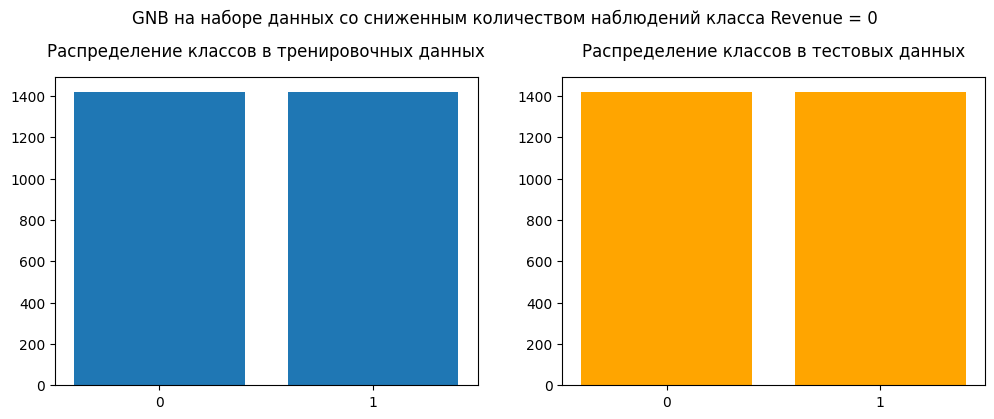

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Mean val balanced accuracy (5 folds): 0.8287562832827353
Test balanced Accuracy: 0.8261053114549385


In [77]:
#Random Under Sampling

RUS = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

X_resampled, y_resampled = RUS.fit_resample(X_train, y_train)

gnb = GaussianNB()
gnb_rus_sign, gnb_rus_sign_data, gnb_rus_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test, 
                                                                         'GNB на наборе данных cо сниженным количеством наблюдений класса Revenue = 0')

**Выводы: обучение на наборе данных с меньшим количество признаков и меньшим количеством наблюдений класса Revenue = 0, GNB**

1. Точность (precision) для целевого класса revenue = 1, `0.51` таким образом, базовый оценщик в виде GNB ошибочно прогнозирует, что клиент принесет выручку (revenue=1) для `49%` спрогнозированных наблюдений, при этом полнота (recall) `0.8`, говорит о том, что оценщик находит `~ 80%` клиентов, принесших выручку. При этом оценщик ошибочно прогнозирует, что клиент не принесет выручку для `4%` наблюдений, и пропускает `15%` клиентов, которые выручку не приносят, что аналогично показателям на обучении без устранения дисбаланса классов. 
2. Уменьшение количества наблюдений с показателем revenue = 0 привело к улучшению распознавания клиентов, приносящих выручку (revenue = 1) (прирост метрики recall `7%`)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning:

divide by zero encountered in log



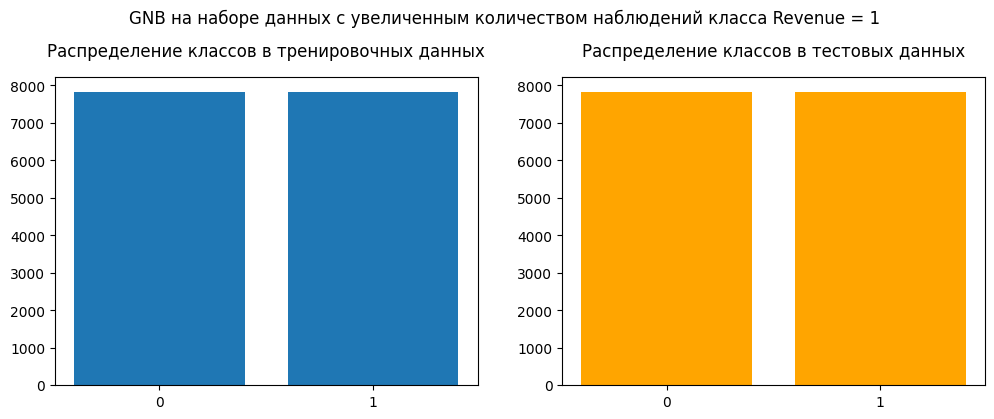

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Mean val balanced accuracy (5 folds): 0.8244784742878828
Test balanced Accuracy: 0.8266835689722862


In [78]:
ROS = RandomOverSampler(random_state=42)

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)


X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)
X_resampled, y_resampled = ROS.fit_resample(X_train, y_train)

gnb = GaussianNB()
gnb_ros_sign, gnb_ros_sign_data, gnb_ros_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test,
                                                                         'GNB на наборе данных c увеличенным количеством наблюдений класса Revenue = 1')

**Выводы: обучение на наборе данных с меньшим количество признаков и большим количеством наблюдений класса Revenue = 1, GNB**

1. Точность (precision) для целевого класса revenue = 1, 0.51 таким образом, оценщик в виде GNB ошибочно прогнозирует, что клиент принесет выручку (revenue=1) для `49%` спрогнозированных наблюдений, при этом полнота (recall) `0.8`, говорит о том, что оценщик находит `~ 80%` клиентов, принесших выручку. При этом оценщик ошибочно прогнозирует, что клиент не принесет выручку для `4%` наблюдений, и пропускает `14%` клиентов, которые выручку не приносят, что тоже аналогично показателям на обучении без устранения дисбаланса классов.
2. Увеличение количества наблюдений с показателем revenue = 1 несколько улучшило распознавание клиентов, приносящих выручку (revenue = 1) (прирост метрики recall `7%`), и немного улучшило нахождение клиентов, не приносящих выручку (прирост метрики recall `3%`). 

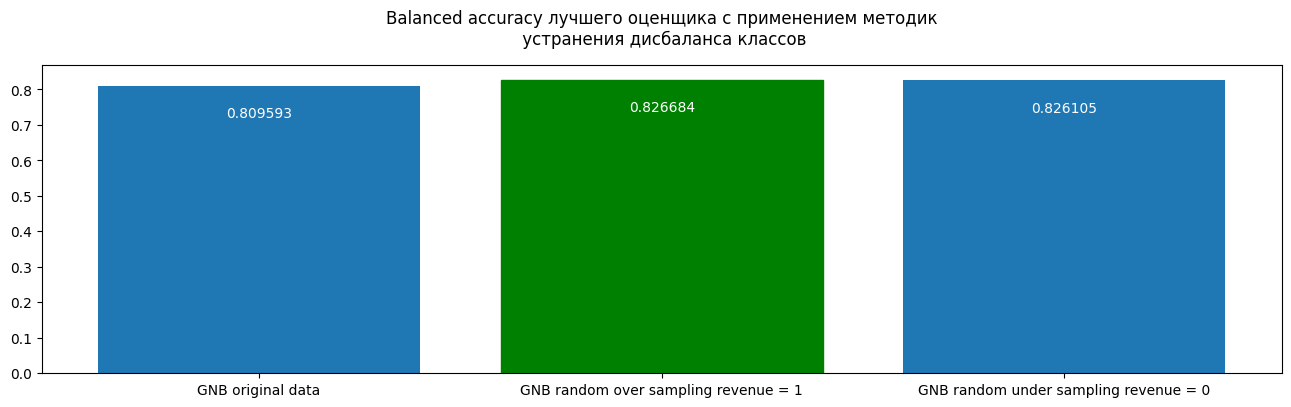

In [79]:
gnb_version = ['GNB original data', 'GNB random over sampling revenue = 1', 'GNB random under sampling revenue = 0']
gnb_metrics = [gnb_sign_metrics[2], gnb_ros_sign_metrics[2], gnb_rus_sign_metrics[2]]

get_comparative_barplot(gnb_version, gnb_metrics, 
                       'Balanced accuracy лучшего оценщика с применением методик\n устранения дисбаланса классов')

**Общий вывод, устранение дисбаланса классов базовыми методами.** 

1. Устранение дисбаланса классов несколько улучшает полноту распознавания клиентов, приносящих выручку и дает сопоставимое качество для распознавания клиентов, выручку не приносящих.
2. Несмотря на улучшение качества, устранение дисбаланса классов эвристиками и математическими методами может нести определенные риски, так как наблюдения и форма обучаемой выборки синтетические. Несмотря на то, что применять алгоритм, обученный с устранением природного дисбаланса классов безопасно, окончательную эффективность устранения дисбаланса классов возможно проверить только после выпуска модели в прод. 

## **5. Подбор гиперпараметров для базовых алгоримов на полном и сокращенном наборах данных.**

**5.1. KNN на полном наборе данных**

In [80]:
knn_params = {'n_neighbors': range(2, 10, 2),
              'weights' : ['uniform', 'distance'],
              'metric' : ['minkowski', 'euclidean', 'manhattan'],
              'p' : [1, 2]
    
}
knn_s = KNeighborsClassifier()
knn_a = KNeighborsClassifier()

In [81]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn_gs_all = GridSearchCV(knn_a, param_grid=knn_params, cv=3, scoring='balanced_accuracy')

knn_gs_all.fit(X_train, y_train)

predictions = knn_gs_all.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
knn_gs_all_balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(clf_report)
print(f'Balanced Accuracy: {knn_gs_all_balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2460
           1       0.36      0.32      0.34       429

    accuracy                           0.82      2889
   macro avg       0.62      0.61      0.62      2889
weighted avg       0.81      0.82      0.81      2889

Balanced Accuracy: 0.6116521689692421


**5.2  KNN на наборе данных с сокращенным множеством признаков**

In [21]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn_gs_sign = GridSearchCV(knn_s, param_grid=knn_params, cv=3, scoring='balanced_accuracy')

knn_gs_sign.fit(X_train, y_train)

predictions = knn_gs_sign.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)

knn_gs_sign_balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print(clf_report)
print(f'Balanced Accuracy: {knn_gs_sign_balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2594
           1       0.65      0.46      0.54       489

    accuracy                           0.88      3083
   macro avg       0.78      0.71      0.73      3083
weighted avg       0.86      0.88      0.87      3083

Balanced Accuracy: 0.707568038875303


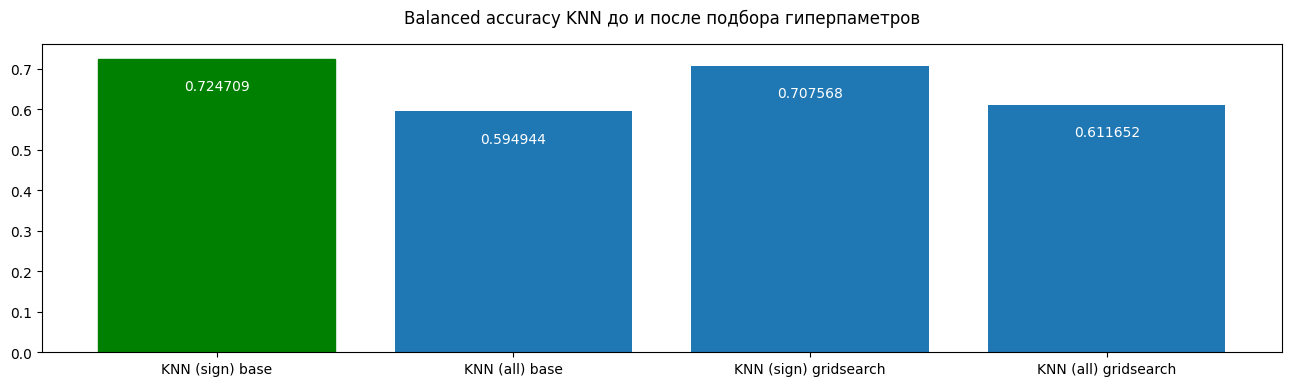

In [22]:
knn_version = ['KNN (sign) base', 'KNN (all) base', 'KNN (sign) gridsearch', 'KNN (all) gridsearch']
knn_metrics = [knn_sign_metrics[1], knn_all_metrics[1], knn_gs_sign_balanced_accuracy, knn_gs_all_balanced_accuracy]

get_comparative_barplot(knn_version, knn_metrics, 
                       'Balanced accuracy KNN до и после подбора гиперпаметров')

**Выводы: Гиперпаметры алгоритма  KNN**

1. Для алгоритма ближайших соседей лучшим оказывается алгоритм с базовыми гиперпараметрами обученный на сокращенном наборе признаков `{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}`
2. Подбор гиперпараметров по сетке привел к увеличению полноты распознавания класса клиентов, приносящих выручку (revenue = 1) для алгоримтов, обученных на полном множестве признаков. На этих же данных подбор гиперпараметров также привела к увеличению общей сбалансированной точности. 
3. В случае сокращенного множества признаков, подбор гиперпараметров по сетке привел к снижению точности определения класса клиентов, приносящих выручку (revenue = 1), что также понизило общую сбалансированную точность алгоритма. 

**5.3. GNB на полном наборе данных**

Для оптимизации гиперпараметра  `priors`, отвечающего за предшествующие вероятности классов, рассмотрим ROC кривую базового алгоритма.  

Text(0.5, 1.0, 'ROC-curve GNB (all) base version')

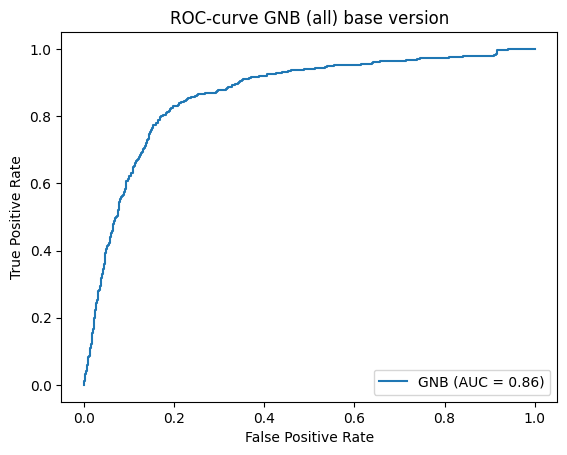

In [23]:
probas = gnb_all.predict_proba(gnb_all_data[1])

fpr, tpr, thresholds = roc_curve(y_true=np.array(gnb_all_data[3]), y_score=probas[:, 1])
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='GNB')

display.plot()
plt.title('ROC-curve GNB (all) base version')

Text(0.5, 1.0, 'ROC-curve GNB (sign) base version')

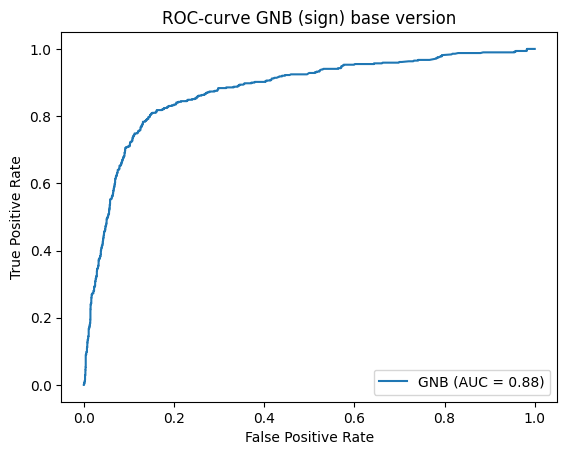

In [24]:
probas = gnb_sign.predict_proba(gnb_sign_data[1])

fpr, tpr, thresholds = roc_curve(y_true=np.array(gnb_sign_data[3]), y_score=probas[:, 1])
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='GNB')

display.plot()
plt.title('ROC-curve GNB (sign) base version')

In [25]:
gnb_params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10],
              'priors' : [[0.8, 0.2],[0.65, 0.35], [0.5, 0.5], [0.2, 0.8], [0.35, 0.65]]
            }

gnb_a = GaussianNB()
gnb_s = GaussianNB()

In [26]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb_gs_all = GridSearchCV(gnb_a, param_grid=gnb_params, cv=3, scoring='balanced_accuracy')

gnb_gs_all.fit(X_train, y_train)

predictions = gnb_gs_all.best_estimator_.predict(X_test)
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
gnb_gs_all_balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print(clf_report)
print(f'Balanced Accuracy: {gnb_gs_all_balanced_accuracy}')

divide by zero encountered in log


              precision    recall  f1-score   support

           0       0.96      0.80      0.88      2460
           1       0.42      0.83      0.56       429

    accuracy                           0.81      2889
   macro avg       0.69      0.82      0.72      2889
weighted avg       0.88      0.81      0.83      2889

Balanced Accuracy: 0.8157314230484962


**5.4. GNB на полном наборе данных**

In [27]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df_significant.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb_gs_sign = GridSearchCV(gnb_s, param_grid=gnb_params, cv=3, scoring='balanced_accuracy')

gnb_gs_sign.fit(X_train, y_train)

predictions = gnb_gs_sign.best_estimator_.predict(X_test)
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
gnb_gs_sign_balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print(clf_report)
print(f'Balanced Accuracy: {gnb_gs_sign_balanced_accuracy}')

divide by zero encountered in log


              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Balanced Accuracy: 0.8284017860943849


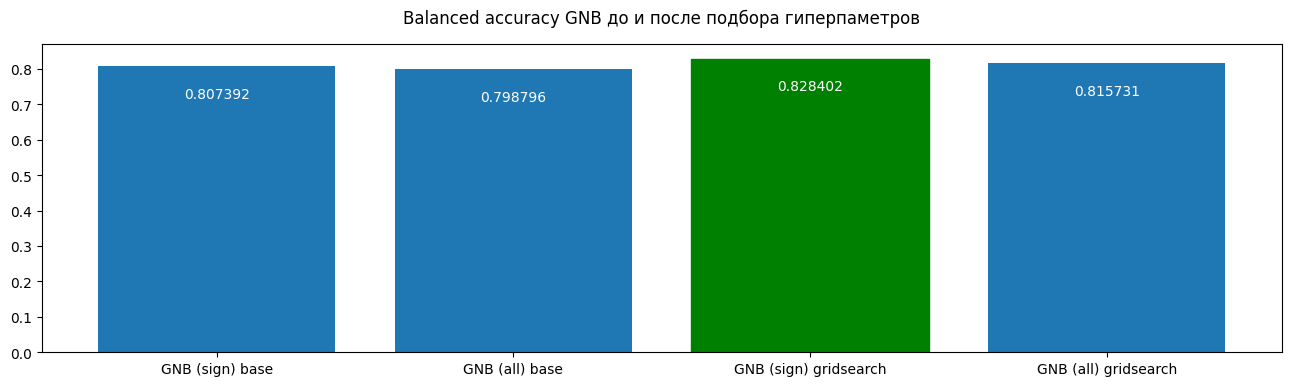

In [28]:
gnb_version = ['GNB (sign) base', 'GNB (all) base', 'GNB (sign) gridsearch', 'GNB (all) gridsearch']
gnb_metrics = [gnb_sign_metrics[1], gnb_all_metrics[1], gnb_gs_sign_balanced_accuracy, gnb_gs_all_balanced_accuracy]

get_comparative_barplot(gnb_version, gnb_metrics, 
                       'Balanced accuracy GNB до и после подбора гиперпаметров')

**Выводы: Гиперпаметры алгоритма  GNB**

1. Для алгоритма ближайших соседей лучшим по сбалансированной точности оказывается алгоритм, обученный на сокращенном множестве признаков с  гиперпараметрами `{'priors': [0.5, 0.5], 'var_smoothing': 1e-13}`, то есть исходящий из предположения равновероятности классов. 
2. Подбор гиперпараметров по сетке привел к повышению полноты определения класса клиентов, приносящих выручку (revenue = 1) и снижению полноты для клиентов, не приносящих выручку для алгоритмов, обученных как на полном, так и на сокращенном множестве признаков. 
3. Подбор гиперпараметров по сетке привел к увеоичению общей точности алгоритмов в обоих случаях, и подобранные гиперпараметры позволили увеличить общую сбалансированную точность алгоритма на `2%`. 

Выбор лучших гиперпараметров зависит от бизнес-цели. В обоих случаях лучше выбрать вариант алгоритма, обученного на скоращенном множестве признаков, так как сокращенное множество признаков позволяет хранить для дообучения меньше данных, и также помогает избавиться от необходимости искуственного устранения аномалий. Если важно определение обоих классов или более важно определение класса клиентов, приносящих выручку, то подбор гиперматеров следует провести согласно найденным по сетке, если же  более важны клиенты, выручку не приносящие (revenue = 0), следует оставить базовые гиперпараметры, так как полнота — количество найденных клиентов с revenue = 0(recall) выше. 

Прежде чем сделать конечный вывод о выбранном лучшем алгоритме, обучим лучший по качеству алгоритм (Gaussian NB, набор данных с сокращенным множеством признаков) без логарифмирования признаков.

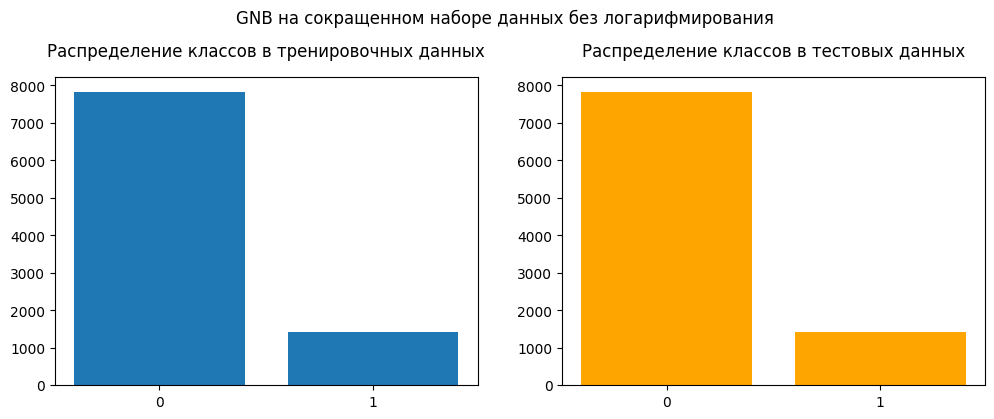

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2594
           1       0.52      0.57      0.55       489

    accuracy                           0.85      3083
   macro avg       0.72      0.74      0.73      3083
weighted avg       0.86      0.85      0.85      3083

Mean val balanced accuracy (5 folds): 0.7459051671605856
Test balanced Accuracy: 0.7356799472748974


In [29]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb = GaussianNB()

gnb_sign_no_lg, gnb_sign_data_no_lg, gnb_sign_no_lg_metrics = get_train_report(gnb, X_train, X_test, y_train, y_test, 
                                                             'GNB на сокращенном наборе данных без логарифмирования')

## **6. Общий вывод. Обучение алгоритмов.**

В ходе обучения оценщиков удалось достичь максимального качества по метрике сбалансированной точности `0.83` (Gaussian NB, 'priors': [0.5, 0.5], 'var_smoothing': 1e-13} по метрике balanced accuracy. Для задач определения обоих классов максимально качественно и при важности полноты определения клиентов, приносящих выручку (recall, найти всех, кто приносит revenue = 1) следует выбрать классификатор, основанный на теореме Байеса с предшествующим логарифмированием данных.  

Если же более важно полнота для класса клиентов, не приносящих выручку, то можно также рассмотреть алгоритм KNN, наиболее полно по метрике (recall) выделяющий объекты класса revenue = 0. 

Логарифмирование является необходимой предобработкой для соответствия математическим допущениям, алгоритма (корректируется форма распределений признаков). В будущем можно также протестировать предобратку альтернативными методами (например, MinMaxScaler), но логарифмирование удобно тем, что меньшие значения логарифма соответствуют меньшим значения признака и наборот, что удобно при интерпретации вклада признаков в ответ модели.

Поскольку проект делается в условиях невозможности уточнения цели, как лучший выбран алгоритм с наивысшей сбалансированной точностью, то есть классификатор, основанный на теореме Байеса. 

## **7. Анализ влияния признаков на оценщиков.** \
**7.1 Permutation Importance (перестановочная важность)**

**7.1.1. Перетасовочная важность и размерность пространства признаков**

In [30]:
perm = PermutationImportance(gnb_all).fit(gnb_all_data[1], gnb_all_data[3])

eli5.show_weights(perm, feature_names=list(df.columns.drop('Revenue')))

Weight,Feature
0.1038 ± 0.0072,PageValues
0.0011 ± 0.0007,BounceRates
0.0007 ± 0.0016,Browser
0.0003 ± 0.0000,Region
0.0001 ± 0.0009,TrafficType
0 ± 0.0000,Weekend
0 ± 0.0000,SpecialDay_categorical
0.0000 ± 0.0015,OperatingSystems
-0.0005 ± 0.0007,VisitorType
-0.0005 ± 0.0038,Month


In [31]:
perm = PermutationImportance(gnb_sign).fit(gnb_sign_data[1], gnb_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1412 ± 0.0044,PageValues
0.0005 ± 0.0012,SpecialDay
0.0003 ± 0.0056,Informational
-0.0002 ± 0.0009,BounceRates
-0.0054 ± 0.0028,Administrative
-0.0058 ± 0.0024,ProductRelated


**Вывод: Перетасовочная важность и размерность пространства признаков**

1. Перетасовочная важность позволяет наглядно обосновать причину, по которой уменьшение количества признаков привело к улучшению качества модели — были удалены признаки, имеющие малый (меньше одной сотой 0.01) или отрицательные веса.
2. Отрицательные веса не позволяют заключить о неинформативности признаков в обоих случаях. Случайная перетасовка практически не меняет качество модели.

**7.1.2. Перетасовочная важность и балансировка обучающих данных для набора данных с сокращенным пространством признаков.** 

In [32]:
perm = PermutationImportance(gnb_sign).fit(gnb_sign_data[1], gnb_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1367 ± 0.0100,PageValues
0.0003 ± 0.0012,BounceRates
0.0003 ± 0.0019,SpecialDay
0.0001 ± 0.0017,Informational
-0.0045 ± 0.0028,ProductRelated
-0.0046 ± 0.0036,Administrative


In [33]:
perm = PermutationImportance(gnb_rus_sign).fit(gnb_rus_sign_data[1], gnb_rus_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1508 ± 0.0105,PageValues
0.0073 ± 0.0037,Informational
-0.0025 ± 0.0013,BounceRates
-0.0028 ± 0.0027,SpecialDay
-0.0056 ± 0.0013,Administrative
-0.0084 ± 0.0033,ProductRelated


In [34]:
perm = PermutationImportance(gnb_ros_sign).fit(gnb_ros_sign_data[1], gnb_ros_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1552 ± 0.0083,PageValues
0.0058 ± 0.0049,Informational
-0.0001 ± 0.0020,SpecialDay
-0.0013 ± 0.0015,BounceRates
-0.0037 ± 0.0038,Administrative
-0.0069 ± 0.0029,ProductRelated


**Вывод: Перетасовочная важность и балансировка обучающих данных.**
1. Можно предположить, что изменение баланса классов увеличивает чувствительность алгоритма к признакам, изменение заметно в сотых и тысячных долях весов признаков.
2. Базовые варианты балансировки не меняют порядка важности признаков. 

**7.1.3. Перетасовочная важность лучшего и худшего алгоритмов**

In [35]:
#Лучший алгоритм
perm = PermutationImportance(gnb_sign).fit(gnb_sign_data[1], gnb_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1393 ± 0.0094,PageValues
0.0003 ± 0.0038,Informational
-0.0002 ± 0.0012,BounceRates
-0.0008 ± 0.0029,SpecialDay
-0.0060 ± 0.0038,ProductRelated
-0.0066 ± 0.0029,Administrative


In [36]:
#Худший алгоритм
perm = PermutationImportance(knn_all).fit(knn_all_data[1], knn_all_data[3])

eli5.show_weights(perm, feature_names=list(df.columns.drop('Revenue')))

Weight,Feature
0.0212 ± 0.0031,PageValues
0.0028 ± 0.0017,ExitRates
0.0012 ± 0.0042,SpecialDay_categorical
0.0008 ± 0.0012,Administrative_Duration
0.0007 ± 0.0000,SpecialDay
0.0006 ± 0.0031,Browser
0.0004 ± 0.0025,Informational
-0.0003 ± 0.0021,VisitorType
-0.0005 ± 0.0031,BounceRates
-0.0006 ± 0.0041,TrafficType


**Вывод: Перетасовочная важность лучшего и худшего алгоритмов**

1. Размерность пространства признаков влияет на чувствительность алгоритма в том числе к наиболее значимым признакам — признак PageValues является наиболее важным в обоих случаях, но для худшего алгоритма (обученного не пространстве признаков большей размерности) имеет меньший вес. Данная гипотеза треюует уточнения, так как сокращение размерности пространства признаков в том числе позволило сохранить большее количество наблюдений. 
2. Изменения весов признаков, следующих после самого важного в лучшем алгоритме не превышают +/- 0.01. Возможно данные признаки значимы во взаимодействии, а не по отдельности и их перетасовка по очереди не сильно путает алгоритм.  

**Общий вывод: Перетасовочная важность**

1. Размерность пространства признаков вероятно влияет на чувствительность алгоритма к значимым признакам.
2. Исключенные в сокращенном наборе данных имели незначительное, но путающее влияние на модель, откуда можно понять причину увеличения качества при сокращении размерности пространства признаков.

Перетасовочная важность имеет ограничение, связанное с тем, что каждый признак оценивается изолировано и, кроме того, перетасовочная важность не позволяет увидеть, как конкретно значение каждого признака влияет на вероятность прогноза. Для того, чтобы уточнить эти вопросы далее рассмотрены значение Шэпли для лучшего алгоритма с лучшей комбинацией признаков, и проанализированы несколько индивидуальных прогнозов. 

**7.2 Значения Шэппли лучшего алгоритма на сокращенном наборе данных (GaussianNB)**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


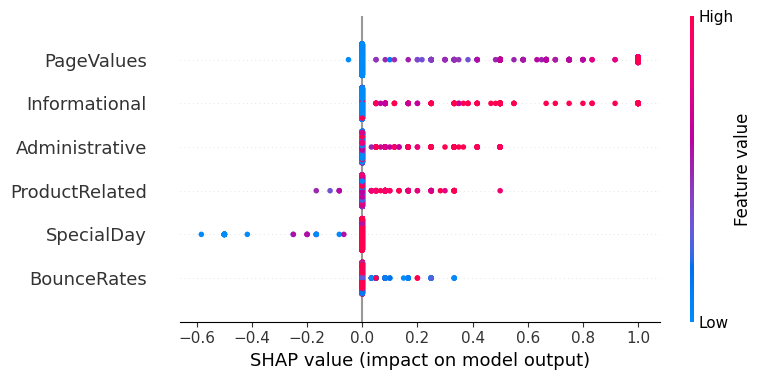

In [37]:
median = np.median(gnb_sign_data[0], axis=0).reshape((1, gnb_sign_data[0].shape[1]))

explainer = shap.Explainer(gnb_sign.predict, median)
shap_values = explainer(gnb_sign_data[1])

shap.summary_plot(shap_values, gnb_sign_data[1], feature_names=list(df_significant.columns.drop('Revenue')))

**Выводы: значения Шэппли на наборе данных с сокращенным множеством признаков**

1. Высокие значения переменных `PageValues`, `Informatinal`, `Administrative`, `ProductRelated`, повышают вероятность прогноза положительного класса. При этом влияние переменной `PageValues` является более плавным (выше значение -> выше вероятность), чем для остальных (высота значения не связана линейно с размером его вклада)
2.  Низкие значения переменной `SpecialDay`  в некоторых случаях оказывают сильное влияние на понижение вероятности прогноза положительного класса. При этом высокие значения данного признака практически не влияют на прогноз.
3.  На основе вывода выше в будущем можно пересмотреть смысл и формат сбора переменной `SpecialDay`
4.  Низкие значения `BounceRates` приводят к повышению вероятности прогноза положительного класса. 

In [38]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#Отключен Warning связанный с обучением модели на данных в виде np.array и pd.DataFrame
explainer = ClassifierExplainer(gnb_sign, pd.DataFrame(gnb_sign_data[1], columns=list(df_significant.columns.drop('Revenue'))), 
                                gnb_sign_data[3], shap='kernel', cats=df_significant.columns.drop('Revenue'))


#explainer = ClassifierExplainer(gnb_sign, pd.DataFrame(gnb_sign_data[1]), 
         #                       gnb_sign_data[3], shap='kernel', cats=df_significant.columns.drop('Revenue'))

db = ExplainerDashboard(explainer)

In [ ]:
db.run()

**7.3. Анализ индивидуальных прогнозов**

Как и значения Шепли, индивидуальные прогнозы рассмотрены на уровне лучшей комбинации алгоритма и данных (Gaussian NB на скоращенном множестве признаков). 
К рассмотрению взяты:

- наблюдения, со 100% вероятностью положительного и отрицательного классов
- наблюдения, где вероятность обоих классов приблизительно равна
- наблюдения, где вероятность одного из классов больше, чем другого

- Средняя вероятность положительного класса по набору данных: 15%

**1. Наблюдения, со 100% вероятностью положительного и отрицательного классов**

**1.1. Index 440** 
- Вероятности: 1 - 0.1, 0 - 99.9 
- Ожидаемое значение: 0 
- Для данного наблюдения вероятность быть причисленным к положительному классу была понижена около нулевыми значениями по длительности посещения страниц и не нулевым значением отказов по странице `BounceRates`

**1.2. Index 273** 
- Вероятности: 1 - 100, 0 - 0 
- Ожидаемое значение: 1 
- Для данного наблюдения вероятность быть причисленным к положительному классу повышалась благодаря большим длительностям посещения страниц и низкому значению отказов по странице `BounceRates`

**2. Наблюдения, со преобладающей вероятностью одного из классов**

**2.1. Index 431** 
- Класс с преобладающей вероятностью: 1 
- Ожидаемое значение: 0  
- Для данного наблюдения поведение вероятности аналогично наблюдению 273, при этом понижает вероятность около нулевое значение переменной `PageValues`

**2.2. Index 1875** 
- Класс с преобладающей вероятностью: 1 
- Ожидаемое значение: 1 
- Для данного наблюдения вероятность быть причисленным к положительному классу повышалась благодаря большим длительностям посещения страниц

**3. Наблюдения, со схожей вероятностью обоих классов**

**3.1. Index 2411** 
- Вероятности: 1 - 50.5, 0 - 49.5 
- Ожидаемое значение: 1 
- Для данного наблюдения вероятность быть причисленным к положительному классу повышалась благодаря большим длительностям посещения страниц и низкому значению отказов по странице `BounceRates`. Баланс на понижение обеспечили около нулевые значения по рейтингу двух переменных, также отвечающих за страницы сайта. 

**3.2. Index 2872** 
- Вероятности: 1 - 49.9, 0 - 50.1 
- Ожидаемое значение: 0
- Для данного наблюдения поведение вероятности аналогично наблюдению 2411

**4. Общие выводы по анализу индивидуальных прогнозов.**

1. Для всех проанализированных категорий наблюдений переменная `SpecialDay` оказывает малые влияния, в отличие от других признаков, но чем ниже значение этого признака, тем сильнее его вклад в прогноз (понижение вероятности положительного класса). Кроме того, при разведовательном анализе было обнаружено, что эта переменная разрежена (содержит много нулей). Также синтетические данные с изменными значениями этого признака показывали, что он может быть значим при лучшей детализации иных диапазонах.  Следует пересмотреть логирование дней до праздника.
2. Во всех случаях наибольшее влияние на повышение вероятности положительного класса (revenue = 1) оказывают признаки, связанные с длительностью посещения страниц. Для большинства наблюдений, больший вклад в повышение вероятности несет признак `PageValues`

## **8. Общий вывод: анализ важности признаков**

1. Наиболее значимые признаки в среднем по всему набору данных связаны с длительностью пребывания на разделах сайта. Переменной с максимальной средней важностью является переменная `PageValues`, причем значения Шепли для данной переменной говорят о практически линейной связи высоких значений и высоких вероятностях положительного класса. Однако в наборе данных есть наблюдения, для которых PageValues = 0 и при этом целевой класс равен 1, следовательно данный признак не может рассматриваться изолировано.
2. Регистрация близости дней к праздникам (переменная `SpecialDay`) нуждается в тестировании новых методов логирования. Синтетические эксперименты показывают, что во взаимосвязи с другими признаками она может оказывать значимое влияния на изменение вероятности положительного класса. 
3. Полученные значия метрик для алгоримтов, протестированных на двух комбинациях признаков позволяют выдвинуть гипотезу о том, что для построения наиболее точной модели достаточно непрерывных признаков. Для настоящего множества данных категориальные признаки путают модель. Однако не стоит забывать о сезонности электронной коммерции и для окончательного понимания важности категориальных признаков, особенно чувствительных ко времени, необходимо набрать больше данных. 

## **9. Заключение**

Проведенная работа показывает важность экспериментов с размерностью пространства признаков и анализа получаемых результатов. Благодаря данным действиям возможно:
- сократить размерность пространства признаков и уменьшить набор данных, который нужно хранить для дообучения модели
- сократить размерность пространства признаков и ускорить таким образом работу модели
- выявить признаки, нуждающиеся в доработке для сбора
- выдвинуть гипотезы о поведении целевой переменной во взаимосвязи с признаками